In [1]:
import pandas as pd
import numpy as np
from yahoo_fin import stock_info as si
import datetime
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from datetime import date
import concurrent.futures
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
gc.enable()

In [2]:
def get_tickers():
    '''Get a list of tickers in US market'''
    # Get lists of tickers and put them in a set
    sp500 = set(si.tickers_sp500())
    nasdaq = set(si.tickers_nasdaq())
    dow = set(si.tickers_dow())
    other = set(si.tickers_other())
    total = set.union(sp500, nasdaq, dow, other)

    # Find out the undesired tickers(such as tickers with warrants or rights)
    filter_lst = ['W', 'R', 'P', 'Q', 'U', 'T', 'L', 'Z']
    bad_tickers = set()
    for i in total:
        if (len(i) >= 5 and i[-1] in filter_lst) or '$' in i or len(i) == 0:
            bad_tickers.add(i)

    # Subtract the undesirable tickers from the ticker set
    good_tickers = total - bad_tickers
    # Return the remaining tickers in a list
    return list(good_tickers)


In [3]:
def get_RSI(prices):
    '''calculate the RSI using the given prices'''
    # calculate returns
    returns = prices.pct_change().iloc[1:]*100
    # calculate average gain and average loss
    avgGain = returns[returns > 0].sum()/len(returns)
    avgLoss = returns[returns < 0].sum()/len(returns)*-1
    # calculate RSI and return the result
    RSI = 100 - (100/(1+(avgGain/avgLoss)))
    return RSI


def get_features(ticker):
    '''collect features for technical analysis of one ticker'''

    # imagine we're back to 180 days ago
    # then 180 days ago becomes "now", and 360 days ago becomes "past". 
    # we'll use the "now" and "past" data to obtain features
    # the current date now becomes 180 days in the future, we'll use the "future" data to obtain target

    future = date.today()
    now = future - datetime.timedelta(180)
    past = now - datetime.timedelta(180)

    # get stock price for features and targets respectively
    try:
        stockDataFeature = si.get_data(ticker, start_date=past, end_date=now)
        stockDataTarget = si.get_data(ticker, start_date=now, end_date=future)
    # if failed, return an array of NAs
    except:
        return np.repeat(pd.NA, 12)

    pricesFeatures = stockDataFeature['adjclose']
    pricesTarget = stockDataTarget['adjclose']
    
    # extract closing price, 180 days max and 180 days min for the "now" data
    currentClose = pricesFeatures[-1]
    highest = pricesFeatures.max()
    lowest = pricesFeatures.min()

    # calculate featuers
    SMA = pricesFeatures.mean()
    EMA = pricesFeatures.ewm(span=14, adjust=False).mean()[0]
    MOM = currentClose - pricesFeatures[0]
    STCK = (currentClose - lowest)/(highest - lowest)*100
    MACD = SMA - pricesFeatures.iloc[::-1][0:14].mean()
    RSI = get_RSI(pricesFeatures)
    williamsR = (highest - currentClose)/(highest - lowest)
    ADI = (currentClose - lowest)-(highest - currentClose) / (highest - lowest)
    avgVolume = stockDataFeature['volume'].mean()
    diff = (currentClose - SMA)/SMA
    returns = (currentClose - pricesFeatures[0])/pricesFeatures[0]*100


    # calculate targets
    target = (pricesTarget[-1]-pricesTarget[0])/pricesTarget[0]*100

    # return features and target
    return [ticker, currentClose,SMA, EMA, MOM, STCK, MACD, RSI,williamsR, ADI, avgVolume, diff,returns,target]






In [4]:
def collect_data(goodTickers):
    '''Use multithreading to get information from the prepare_features() function'''

    # run get_features for each of the goodTickers
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data = executor.map(get_features, goodTickers)

    df = pd.DataFrame()
    
    # store the results in df
    for i in data:
        try:
            df[i[0]] = i[1:14]
        except:
            pass

    
    return df



In [5]:
# obtain data for each of the goodTickers, and rename the data index
goodTickers = get_tickers()
data = collect_data(goodTickers)
data.index = ['ClosingPrice','SMA', 'EMA', 'MOM', 'STCK', 'MACD', 'RSI','williamsR', 'ADI', 'avgVolume', 'diff','returns','target']



C:\Users\sunny\AppData\Local\Temp/ipykernel_2308/3934212778.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  RSI = 100 - (100/(1+(avgGain/avgLoss)))
C:\Users\sunny\AppData\Local\Temp/ipykernel_2308/3934212778.py:45: RuntimeWarning: invalid value encountered in double_scalars
  STCK = (currentClose - lowest)/(highest - lowest)*100
C:\Users\sunny\AppData\Local\Temp/ipykernel_2308/3934212778.py:6: RuntimeWarning: invalid value encountered in double_scalars
  avgGain = returns[returns > 0].sum()/len(returns)
C:\Users\sunny\AppData\Local\Temp/ipykernel_2308/3934212778.py:7: RuntimeWarning: invalid value encountered in double_scalars
  avgLoss = returns[returns < 0].sum()/len(returns)*-1
C:\Users\sunny\AppData\Local\Temp/ipykernel_2308/3934212778.py:48: RuntimeWarning: invalid value encountered in double_scalars
  williamsR = (highest - currentClose)/(highest - lowest)
C:\Users\sunny\AppData\Local\Temp/ipykernel_2308/3934212778.py:49: RuntimeWarning: invalid value encount

In [6]:
# create a copy just in case
dataCopy = data

# take a look of the min, max and the number of NAs for each feature
overview = pd.DataFrame()
for i in range(0, 11):
    overview[data.index[i]] = [data.iloc[i, ].min(), data.iloc[i, ].max(),pd.isna(data.iloc[i, ]).sum()]
overview.index = ["min",'max','NA']
overview.T

    

,min,max,NA
ClosingPrice,0.150000,4.622000e+03,0.0
SMA,0.299032,5.211140e+03,0.0
EMA,-3.210830,5.024000e+03,0.0
MOM,-998.880005,2.618099e+02,0.0
STCK,0.000000,1.000000e+02,4.0
MACD,-135.839722,3.985110e+02,0.0
RSI,0.000000,1.000000e+02,4.0
williamsR,0.000000,1.000000e+00,4.0
ADI,-1.000000,3.446876e+02,4.0
avgVolume,0.000000,1.242872e+08,0.0


In [7]:
# since we only have a few NAs, we can just drop any stock tickers with NA
data = data.dropna(axis=1, thresh=11)


In [8]:
# transpose the data frame
data = data.T

# convert the continuous values in target into discrete values
data['target'] = np.multiply(data['target'] > 10, 1)



In [9]:
# split data into features and target
features = data.iloc[:, :12]
target = data.iloc[:, 12]

# standarlize features
scaler = MinMaxScaler()
scaler.fit(features)
features.iloc[:, :] = scaler.transform(features)
max = scaler.data_max_
min = scaler.data_min_
with open("mins_and_maxs.pickle", 'wb') as f:
    pickle.dump([min,max], f)


In [10]:
from skfeature.function.similarity_based import fisher_score
ranks = fisher_score.fisher_score(np.array(features), np.array(target), mode='rank')
print(ranks)



[ 3  5  1  7  4  2  0  6  8 11 10  9]


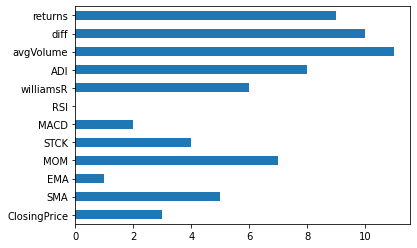

In [11]:
feature_importance = pd.Series(ranks, features.columns)
feature_importance.plot(kind='barh')
plt.show()


In [12]:
data = data.drop(columns=feature_importance.sort_values().index.values[0:2])


<AxesSubplot:>

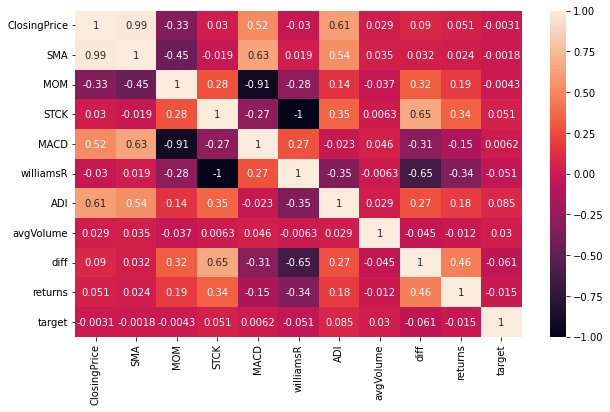

In [13]:
# draw a correlation heatmap
corr = data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)



In [14]:
# convert the upper triangle of the heatmap into a data frame 
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
upper


C:\Users\sunny\AppData\Local\Temp/ipykernel_2308/4263490579.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


,ClosingPrice,SMA,MOM,STCK,MACD,williamsR,ADI,avgVolume,diff,returns,target
ClosingPrice,NaN,0.989615,-0.328256,0.030075,0.520949,-0.030075,0.608651,0.028555,0.089574,0.051388,-0.003081
SMA,NaN,NaN,-0.447638,-0.019190,0.633638,0.019190,0.538737,0.034648,0.031987,0.024009,-0.001758
MOM,NaN,NaN,NaN,0.279547,-0.908576,-0.279547,0.140705,-0.036670,0.324178,0.185943,-0.004253
STCK,NaN,NaN,NaN,NaN,-0.273868,-1.000000,0.350107,0.006330,0.654684,0.339733,0.050796
MACD,NaN,NaN,NaN,NaN,NaN,0.273868,-0.022723,0.045563,-0.307423,-0.146633,0.006206
williamsR,NaN,NaN,NaN,NaN,NaN,NaN,-0.350107,-0.006330,-0.654684,-0.339733,-0.050796
ADI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028523,0.268550,0.182292,0.084875
avgVolume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.045463,-0.012059,0.030420
diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463412,-0.060986
returns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014958


In [15]:
# for features with a correlation grater than 0.8, remove the feature that has lower correlation with the target
toRemove = []
for i in upper.index:
    for j in upper.columns:
        if abs(upper.loc[i, j]) > 0.8:
            print(i, upper.loc[i, "target"], j, upper.loc[j, "target"])
            if abs(upper.loc[i, "target"]) < abs(upper.loc[j, "target"]):
                toRemove.append(i)
            else:
                toRemove.append(j)
print(toRemove)
features = features.drop(columns=np.unique(toRemove))


ClosingPrice -0.003081400424459647 SMA -0.001758178359622563
MOM -0.004252719246767861 MACD 0.006205938789545847
STCK 0.05079608077971585 williamsR -0.05079608077971584
['SMA', 'MOM', 'williamsR']


In [16]:
# split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(np.array(features), np.array(target), test_size=.2)

In [17]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

naive_bayes = GaussianNB()
SGD = SGDClassifier()
KNN = KNeighborsClassifier()
randomForest = RandomForestClassifier()
XGB = XGBClassifier()
SVM = svm.SVC()
logistic = LogisticRegression()
decTree = DecisionTreeClassifier()

models = [naive_bayes,SGD,KNN, randomForest,SVM,XGB,logistic,decTree]
for i in models:
    print(i)
    print(cross_val_score(i, features,target, cv=10, scoring='accuracy').mean())


GaussianNB()
0.8513255272033826
SGDClassifier()
0.872322435049167
KNeighborsClassifier()
0.8553344115773106
RandomForestClassifier()
0.869685081469798
SVC()
0.872322435049167
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
0.8627201600434862
LogisticRegression()
0.872322435049167
DecisionTreeClassifier()
0

In [18]:
param_grid = [{
    'kernel': ['linear', 'rbf','sigmoid'],
    'gamma':['auto', 1, 0.1, 0.01, 0.001],
    'C': [0.1, 1, 10, 20]}]
model = GridSearchCV(svm.SVC(), param_grid=param_grid,
                     scoring='accuracy', verbose=2, cv=5)


In [19]:
best_model= model.fit(x_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.5s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.3s
[CV] END ..................C=0.1, gamma=auto, k

In [20]:
goodModel = best_model.best_estimator_
x_train, x_test, y_train, y_test = train_test_split(np.array(features), np.array(target), test_size=.2)
goodModel.fit(x_train, y_train)
y_predict = goodModel.predict(x_test)
acc = metrics.accuracy_score(y_test, y_predict)
print(acc)

with open("model.pickle", 'wb') as f:
    pickle.dump(goodModel, f)


0.8850210970464135
